In [1]:
import numpy as np
import pandas as pd
import pickle

### 定义推荐函数

In [2]:
def find_similar_movies(items_embeddings, movie_index, top_k=10):
    # 获取目标电影的嵌入
    target_emb = items_embeddings[movie_index]  # shape: (embedding_dim,)
    
    # 计算余弦相似度
    norm_items_emb = items_embeddings / np.linalg.norm(items_embeddings, axis=1, keepdims=True)  # 单位化每个电影的嵌入
    norm_target_emb = target_emb / np.linalg.norm(target_emb)  # 单位化目标电影的嵌入
    similarities = np.dot(norm_items_emb, norm_target_emb)  # shape: (num_movies,)
    
    # 排除目标电影本身
    similarities[movie_index] = -1.0  # 设置自身的相似度为 -1，避免被选中
    
    # 获取 Top-K 相似电影
    topk_indices = np.argsort(similarities)[-top_k:][::-1]  # 从大到小排序并取前K个索引
    
    return topk_indices.tolist()

# 找到相似用户
def find_similar_users(users_embeddings, user_index, top_k=10):
    # 获取目标用户的嵌入
    target_emb = users_embeddings[user_index]  # shape: (embedding_dim,)

    # 计算余弦相似度
    norm_users_emb = users_embeddings / np.linalg.norm(users_embeddings, axis=1, keepdims=True)  # 单位化每个用户的嵌入
    norm_target_emb = target_emb / np.linalg.norm(target_emb)  # 单位化目标用户的嵌入
    similarities = np.dot(norm_users_emb, norm_target_emb)  # shape: (num_users,)
    # 排除目标用户本身
    similarities[user_index] = -1.0  # 设置自身的相似度为 -1，避免被选中

    # 获取 Top-K 相似用户
    topk_indices = np.argsort(similarities)[-top_k:][::-1]  # 从大到小排序并取前K个索引

    return topk_indices.tolist()


# 为用户找到推荐电影
def recommend_movies_for_user(users_embeddings, items_embeddings, user_index, top_k=10):
    # 获取目标用户的嵌入
    target_emb = users_embeddings[user_index]  # shape: (embedding_dim,)

    # 计算余弦相似度
    norm_items_emb = items_embeddings / np.linalg.norm(items_embeddings, axis=1, keepdims=True)  # 单位化每个电影的嵌入
    norm_target_emb = target_emb / np.linalg.norm(target_emb)  # 单位化目标用户的嵌入
    similarities = np.dot(norm_items_emb, norm_target_emb)  # shape: (num_movies,)
    # 获取 Top-K 推荐电影
    topk_indices = np.argsort(similarities)[-top_k:][::-1]  # 从大到小排序并取前K个索引

    return topk_indices.tolist()


### 加载已保存的embedding

In [7]:
# 加载时使用以下代码
# 加载 embeddings
dataset = 'ml-25m'
users_embeddings_file = './save/'+dataset+"-unweight"+'/users_embeddings.npy'
items_embeddings_file = './save/'+dataset+"-unweight"+'/items_embeddings.npy'
maps_file = './save/'+dataset+"-unweight"+'/dataset_maps.pkl'
users_embeddings = np.load(users_embeddings_file)
items_embeddings = np.load(items_embeddings_file)


# 加载 maps
with open(maps_file, 'rb') as f:
    loaded_maps = pickle.load(f)

movie_map = loaded_maps['movie_map']
user_map = loaded_maps['user_map']

print("Embeddings and maps loaded successfully.")


Embeddings and maps loaded successfully.


### 为指定电影推荐相似电影

In [9]:

# 为指定电影推荐相似电影
movies_df = pd.read_csv("../data/"+dataset+"/movies.csv")
movie_index = 0
similar_indices = find_similar_movies(items_embeddings, movie_index, top_k=10)

movie_mapping_inverse = {v: k for k, v in movie_map.items()}
user_mapping_inverse = {v: k for k, v in user_map.items()}
target_movie_name = movies_df[movies_df['movieId'] == movie_mapping_inverse[movie_index]]['title'].values[0]
target_movie_type = movies_df[movies_df['movieId'] == movie_mapping_inverse[movie_index]]['genres'].values[0]
similar_ids = [movie_mapping_inverse[indice] for indice in similar_indices]
filtered_df = movies_df[movies_df['movieId'].isin(similar_ids)]
similar_movie_names = filtered_df['title'].tolist()
similar_movie_types = filtered_df['genres'].tolist()

print(f"Target movie: {target_movie_name} ({target_movie_type})")
print(f"Similar movies:")
for name, genre in zip(similar_movie_names, similar_movie_types):
    print(f"{name}: ({genre})")

Target movie: Toy Story (1995) (Adventure|Animation|Children|Comedy|Fantasy)
Similar movies:
Lion King, The (1994): (Adventure|Animation|Children|Drama|Musical|IMAX)
Aladdin (1992): (Adventure|Animation|Children|Comedy|Musical)
Toy Story 2 (1999): (Adventure|Animation|Children|Comedy|Fantasy)
Monsters, Inc. (2001): (Adventure|Animation|Children|Comedy|Fantasy)
Finding Nemo (2003): (Adventure|Animation|Children|Comedy)
Incredibles, The (2004): (Action|Adventure|Animation|Children|Comedy)
Ratatouille (2007): (Animation|Children|Drama)
WALL·E (2008): (Adventure|Animation|Children|Romance|Sci-Fi)
Up (2009): (Adventure|Animation|Children|Drama)
Toy Story 3 (2010): (Adventure|Animation|Children|Comedy|Fantasy|IMAX)


In [10]:
import pandas as pd

# 加载rating.csv文件
ratings = pd.read_csv('../data/ml-25m/ratings.csv')

# 指定的用户Id
user_index = 100
# 映射用户索引到Id
user_id = user_mapping_inverse[user_index]

# 筛选评分大于等于4的电影
filtered_movies = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= 4)]

# 输出电影ID列表
movie_ids = filtered_movies['movieId'].tolist()
# 从电影ID 映射到电影名称
movie_names = [movies_df[movies_df['movieId'] == movie_id]['title'].values[0] for movie_id in movie_ids]

print(f"User {user_id} has rated the following movies 4 or higher:")
for movie_name in movie_names:
    print(f"{movie_name}:  {movies_df[movies_df['title'] == movie_name]['genres'].values[0]}" )



User 125640 has rated the following movies 4 or higher:
Ford v. Ferrari (2019):  Action|Drama
Joker (2019):  Crime|Drama|Thriller
The Machinist (2004):  Drama|Mystery|Thriller
Alita: Battle Angel (2019):  Action|Romance|Sci-Fi|Thriller
Million Dollar Baby (2004):  Drama
Kramer vs. Kramer (1979):  Drama
Interstellar (2014):  Sci-Fi|IMAX
Memento (2000):  Mystery|Thriller
Mother! (2017):  Drama|Horror|Mystery|Thriller
Dunkirk (2017):  Action|Drama|Thriller|War
Blade Runner 2049 (2017):  Sci-Fi
Coco (2017):  Adventure|Animation|Children


In [6]:

# 为指定用户推荐电影
recommended_indices = recommend_movies_for_user(users_embeddings, items_embeddings, user_index, top_k=20)

recommended_movie_ids = [movie_mapping_inverse[indice] for indice in recommended_indices]
# 从电影ID 映射到电影名称
recommended_movie_names = [movies_df[movies_df['movieId'] == movie_id]['title'].values[0] for movie_id in recommended_movie_ids]

print(f"Recommended movies for user {user_id}:")
for movie_name in recommended_movie_names:
    print(f"{movie_name}:  {movies_df[movies_df['title'] == movie_name]['genres'].values[0]}" )


Recommended movies for user 125640:
Ford v. Ferrari (2019):  Action|Drama
Kramer vs. Kramer (1979):  Drama
Joker (2019):  Crime|Drama|Thriller
The Invisible Guest (2016):  Thriller
Mother! (2017):  Drama|Horror|Mystery|Thriller
The Red Sea Diving Resort (2019):  Drama|Thriller
Billionaire Boys Club (2018):  Crime|Drama|Thriller
Brimstone (2016):  Mystery|Thriller|Western
Hostiles (2017):  Adventure|Drama|Western
Three Billboards Outside Ebbing, Missouri (2017):  Crime|Drama
Dunkirk (2017):  Action|Drama|Thriller|War
Mirage (2018):  Drama|Sci-Fi|Thriller
A Star Is Born (2018):  Drama|Romance
Three Identical Strangers (2018):  Documentary
Nocturnal Animals:  Drama|Thriller
Black Mirror:  (no genres listed)
The Body (2012):  Mystery|Thriller
Midsommar (2019):  Drama|Horror|Mystery
Green Book (2018):  Comedy|Drama
Norma Rae (1979):  Drama


In [11]:

# 为指定用户推荐相似用户
user_index = 100
top_k = 10
similar_indices = find_similar_users(users_embeddings, user_index, top_k=top_k)

user_mapping_inverse = {v: k for k, v in user_map.items()}
target_user_id = user_mapping_inverse[user_index]
similar_user_ids = [user_mapping_inverse[indice] for indice in similar_indices]

print(f"Target user: {target_user_id}")
print(f"Similar users:")
for user_id in similar_user_ids:
    print(user_id)

Target user: 125640
Similar users:
33057
39415
156081
90436
138509
42489
91400
38451
57043
65917


# 可视化结果

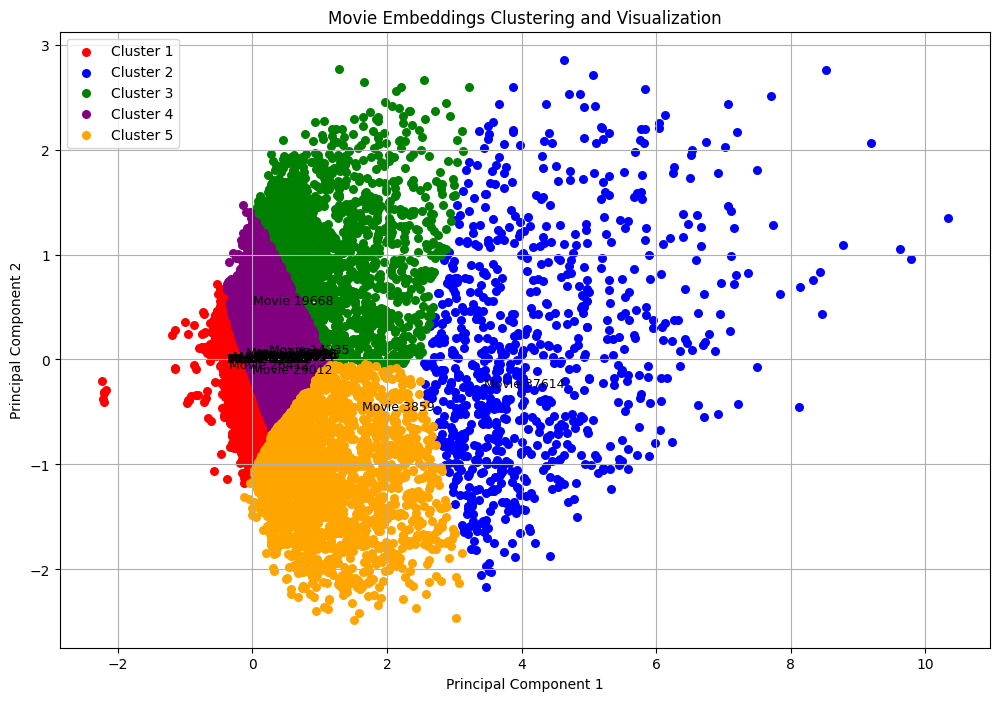

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

# Load embeddings
embeddings = np.load('save/ml-25m-reweight/items_embeddings.npy')  # N x 64

# Dimensionality reduction to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# K-means clustering
num_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Plot the clusters
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(num_clusters):
    plt.scatter(reduced_embeddings[clusters == i, 0], reduced_embeddings[clusters == i, 1], 
                s=30, label=f'Cluster {i+1}', color=colors[i])

# Highlight some random movies
num_samples = 20  # Number of movies to annotate
sample_indices = random.sample(range(len(reduced_embeddings)), num_samples)
for idx in sample_indices:
    x, y = reduced_embeddings[idx]
    plt.text(x, y, f'Movie {idx}', fontsize=9, color='black')

plt.title('Movie Embeddings Clustering and Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()


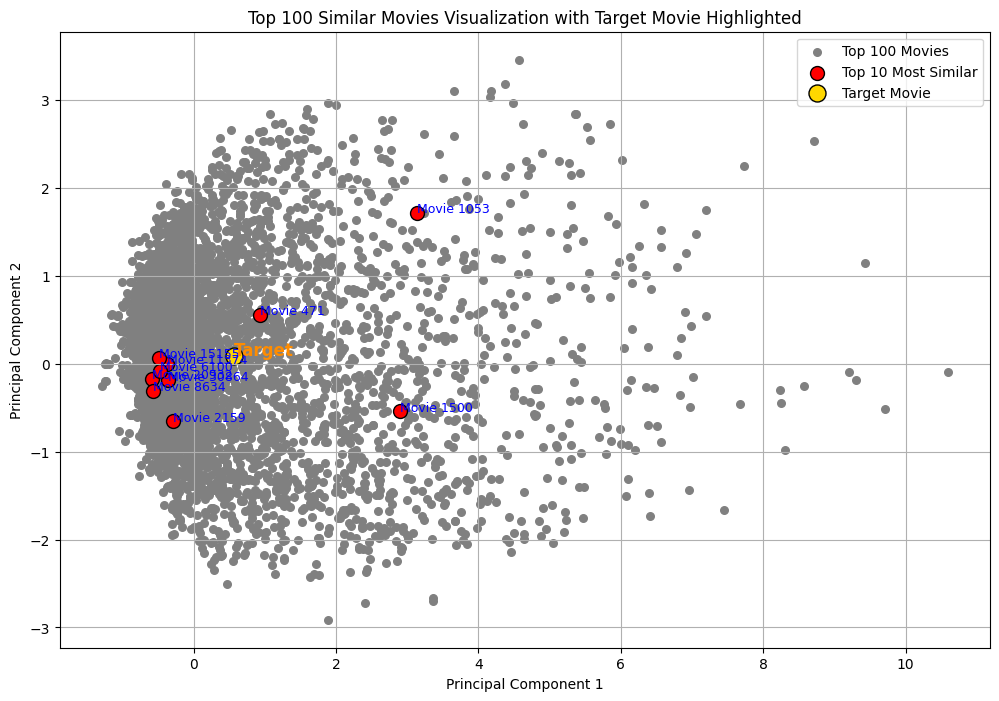

In [21]:
# Re-import necessary libraries after the reset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Assuming embeddings are loaded from a valid source for demonstration purposes
embeddings = np.load('save/ml-25m-unweight/items_embeddings.npy') 

# Specify the movie index
target_index = 100  # Change this to the index of the movie you want to analyze

# Compute cosine similarities between the target movie and all other movies
similarities = cosine_similarity(embeddings[target_index].reshape(1, -1), embeddings).flatten()

# Get the indices of the top 100 most similar movies
top_100_indices = similarities.argsort()[-10001:][::-1][1:]  # Exclude the target itself

# Get the top 10 most similar movies
top_10_indices = top_100_indices[:10]

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
top_100_embeddings = embeddings[top_100_indices]
reduced_top_100 = pca.fit_transform(top_100_embeddings)

# Reduce dimensions for the target movie
target_embedding = embeddings[target_index].reshape(1, -1)
reduced_target = pca.transform(target_embedding)

# Visualization with target movie highlighted
plt.figure(figsize=(12, 8))

# Plot all top 100 movies
plt.scatter(reduced_top_100[:, 0], reduced_top_100[:, 1], s=30, c='gray', label='Top 100 Movies')

# Highlight top 10 most similar movies
for idx in range(10):
    x, y = reduced_top_100[idx]
    plt.scatter(x, y, s=100, color='red', edgecolor='black', label='Top 10 Most Similar' if idx == 0 else None)
    plt.text(x, y, f'Movie {top_10_indices[idx]}', fontsize=9, color='blue')

# Highlight the target movie
plt.scatter(reduced_target[0, 0], reduced_target[0, 1], s=150, color='gold', edgecolor='black', label='Target Movie')
plt.text(reduced_target[0, 0], reduced_target[0, 1], 'Target', fontsize=12, color='darkorange', fontweight='bold')

plt.title('Top 100 Similar Movies Visualization with Target Movie Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()